# Installing Packages

In [ ]:
%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

# Importing Packages

In [1]:
import pandas as pd
import numpy as np

from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DDPG, PPO
from finrl.plot import backtest_stats, backtest_plot, get_baseline, get_daily_return

import ctypes
import gymnasium as gym
from gymnasium import spaces

import itertools
import matplotlib.pyplot as plt
import pyfolio
%matplotlib inline

/home/shlok/MTP/.venv/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Creating Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Global Vars

In [2]:
TICKER_LIST = ['AAPL', 'JPM', 'JNJ', 'TSLA', 'NVDA', 'AMD', 'META', 'AMZN']
INIT_TRADING_AMOUNT = 100000
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2021-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2021-12-31'
TRADE_START_DATE = '2022-01-01'
TRADE_END_DATE = '2023-01-01'

# Downloading Market Data

In [3]:
df = YahooDownloader(start_date=TRAIN_START_DATE,
                     end_date=TRADE_END_DATE,
                     ticker_list=TICKER_LIST).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (6048, 8)


In [4]:
df

Price,date,close,high,low,open,volume,tic,day
0,2020-01-02,72.468285,72.528604,71.223282,71.476622,135480400,AAPL,3
1,2020-01-02,49.099998,49.250000,46.630001,46.860001,80331100,AMD,3
2,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,AMZN,3
3,2020-01-02,123.290207,123.332441,122.538489,123.205739,5777000,JNJ,3
4,2020-01-02,119.573341,119.581825,118.022420,118.471593,10803700,JPM,3
...,...,...,...,...,...,...,...,...
6043,2022-12-30,161.250107,162.272478,160.109079,162.016888,4216600,JNJ,4
6044,2022-12-30,124.544914,124.758522,123.003192,123.346823,9292500,JPM,4
6045,2022-12-30,119.602676,119.682188,117.018608,117.436040,19583800,META,4
6046,2022-12-30,14.600199,14.615184,14.219558,14.320462,310490000,NVDA,4


# Preprocessing Data

In [5]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list=config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

# Data Cleaning
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,TICKER_LIST))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

print("Data Processing Complete.")
processed_full.tail()

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (755, 8)
Successfully added vix
Successfully added turbulence index
Data Processing Complete.


,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
8738,2022-12-29,JNJ,162.080811,162.756304,161.633536,162.071687,2828800.0,3.0,0.713107,164.206682,159.623571,55.786615,49.198871,2.243053,161.484005,157.257353,21.440001,5.070937
8737,2022-12-29,JPM,123.727592,123.774033,122.882430,123.458248,6585200.0,3.0,0.284922,126.104487,119.480237,56.204500,-5.630825,5.726705,123.652070,118.073090,21.440001,5.070937
8742,2022-12-29,META,119.523186,120.288465,115.060690,115.686835,22366200.0,3.0,0.786583,122.916014,111.331913,49.375047,73.457687,9.186739,115.121641,115.928169,21.440001,5.070937
8740,2022-12-29,NVDA,14.589209,14.669133,14.213564,14.388399,354923000.0,3.0,-0.259675,18.546619,14.007306,47.001780,-155.632198,13.239239,16.162705,14.710771,21.440001,5.070937
8739,2022-12-29,TSLA,121.820000,123.570000,117.500000,120.389999,221923300.0,3.0,-19.771700,207.886034,101.033966,32.280616,-140.073211,49.646244,163.392333,188.559334,21.440001,5.070937


# Splitting and Saving the Data

In [6]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))
train.to_csv("./" + config.DATA_SAVE_DIR + "/train_data.csv", index=False)
trade.to_csv("./" + config.DATA_SAVE_DIR + "/trade_data.csv", index=False)

4032
2000


# Trading Wrapper

In [8]:
class InputsTradingEnforcer(ctypes.Structure):
    _fields_ = [
        ("dd_exceeded", ctypes.c_bool),
        ("is_illiquid", ctypes.c_bool),
        ("will_exceed_limit", ctypes.c_bool),
        ("price_deviates", ctypes.c_bool),
    ]

class OutputsTradingEnforcer(ctypes.Structure):
    _fields_ = [
        ("act_TRADE", ctypes.c_bool),
        ("act_BUY", ctypes.c_bool),
    ]

class EnforcerVarsTradingEnforcer(ctypes.Structure):
    _fields_ = [
        ("_policy_state", ctypes.c_int),
        ("t_window", ctypes.c_uint64),
    ]

lib_path = "../policies/TradingEnforcer/libtradingenforcer.so"
lib = ctypes.CDLL(lib_path)

lib.TradingEnforcer_init_all_vars.argtypes = [ctypes.POINTER(EnforcerVarsTradingEnforcer), ctypes.POINTER(InputsTradingEnforcer), ctypes.POINTER(OutputsTradingEnforcer)]
lib.TradingEnforcer_run_via_enforcer.argtypes = [ctypes.POINTER(EnforcerVarsTradingEnforcer), ctypes.POINTER(InputsTradingEnforcer), ctypes.POINTER(OutputsTradingEnforcer)]

class RuntimeEnforcementWrapper(gym.Wrapper):
    def __init__(self, 
                 env, log_file="./enforcement_log.txt", 
                 drawdown_limit=0.10, 
                 concentration_limit=0.20, 
                 min_volume_limit=100000,
                 logging_enabled=True):
        super().__init__(env)
        
        self.log_file = log_file
        self.drawdown_limit = drawdown_limit
        self.concentration_limit = concentration_limit
        self.min_volume_limit = min_volume_limit
        self.logging_enabled = logging_enabled
        
        self.log_handle = open(self.log_file, "w")
        self.log_handle.write("RuntimeEnforcementWrapper initialized.\n")
        self.log_handle.write(f"Settings: DD={drawdown_limit}, Conc={concentration_limit}, Vol={min_volume_limit}\n")
             
        self.stock_dim = env.action_space.shape[0]
        
        self.enforcers = []
        self.inputs_structs = []
        self.outputs_structs = []
        
        for _ in range(self.stock_dim):
            enf = EnforcerVarsTradingEnforcer()
            inp = InputsTradingEnforcer()
            out = OutputsTradingEnforcer()
            
            lib.TradingEnforcer_init_all_vars(ctypes.byref(enf), ctypes.byref(inp), ctypes.byref(out))
            
            self.enforcers.append(enf)
            self.inputs_structs.append(inp)
            self.outputs_structs.append(out)
    
    def _log(self, msg):
        if self.logging_enabled:
            self.log_handle.write(msg + "\n")

    def close(self):
        if hasattr(self, 'log_handle') and not self.log_handle.closed:
            self.log_handle.write("--- End of Logs ---\n")
            self.log_handle.close()
        return super().close()

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

    def step(self, action):
        # Access the underlying FinRL environment to get internal state
        base_env = self.env.unwrapped
        
        # 1. Calculate Current Drawdown
        asset_memory = base_env.asset_memory
        if len(asset_memory) > 0:
            peak_value = max(asset_memory)
            current_value = asset_memory[-1]
            current_drawdown = (peak_value - current_value) / peak_value if peak_value > 0 else 0.0
        else:
            current_drawdown = 0.0

        # 2. Extract State Information
        state = base_env.state
        stock_dim = self.stock_dim
        
        idx_cash = 0
        idx_prices_start = 1
        idx_prices_end = 1 + stock_dim
        idx_shares_start = idx_prices_end
        idx_shares_end = idx_shares_start + stock_dim
        
        current_cash = state[idx_cash]
        current_prices = np.array(state[idx_prices_start:idx_prices_end])
        current_shares = np.array(state[idx_shares_start:idx_shares_end])
        
        # Calculate total portfolio value
        portfolio_value = current_cash + np.sum(current_prices * current_shares)

        # 3. Extract Liquidity (Volume)
        current_volumes = base_env.data['volume'].values

        # --- LOGGING HEADER ---
        self._log(f"\n=== Step {base_env.day} ===")
        self._log(f"Portfolio Value: {portfolio_value:,.2f}")
        # self._log(f"Current Drawdown: {current_drawdown} (Limit: {self.drawdown_limit})")

        safe_action = np.copy(action)
        
        for i in range(self.stock_dim):
            ticker = TICKER_LIST[i] if 'TICKER_LIST' in globals() else f"Stock_{i}"
            
            # A. Populate Inputs for the Enforcer
            self.inputs_structs[i].dd_exceeded = bool(current_drawdown > self.drawdown_limit)
            self.inputs_structs[i].is_illiquid = bool(current_volumes[i] < self.min_volume_limit)
            
            # Concentration Check
            proposed_shares = current_shares[i] + action[i]
            if proposed_shares < 0: proposed_shares = 0
            
            proposed_position_value = proposed_shares * current_prices[i]
            
            projected_concentration = 0.0
            if portfolio_value > 0:
                projected_concentration = proposed_position_value / portfolio_value
                self.inputs_structs[i].will_exceed_limit = bool(projected_concentration > self.concentration_limit)
            else:
                self.inputs_structs[i].will_exceed_limit = False

            self.inputs_structs[i].price_deviates = False 
            
            # B. Populate Proposed Outputs from RL Action
            self.outputs_structs[i].act_TRADE = (abs(action[i]) > 0)
            self.outputs_structs[i].act_BUY = (action[i] > 0)
            
            # --- LOGGING PRE-ENFORCEMENT ---
            if abs(action[i]) > 0: # Only log active trades to reduce noise
                self._log(f"[{ticker}] Agent Action: {'BUY' if action[i]>0 else 'SELL'} {abs(action[i]):.0f} shares @ {current_prices[i]:.2f}")
                self._log(f"    > Drawdown: {current_drawdown:.2%} (Limit: {self.drawdown_limit:.0%}) -> Exceeds: {self.inputs_structs[i].dd_exceeded}")
                self._log(f"    > Liquidity: {current_volumes[i]:,.0f} (Min: {self.min_volume_limit}) -> Illiquid: {self.inputs_structs[i].is_illiquid}")
                self._log(f"    > Concentration: {projected_concentration:.2%} (Limit: {self.concentration_limit:.0%}) -> Exceeds: {self.inputs_structs[i].will_exceed_limit}")
                self._log(f"    Inputs: DD={self.inputs_structs[i].dd_exceeded}, Illiq={self.inputs_structs[i].is_illiquid}, Conc={self.inputs_structs[i].will_exceed_limit}")


            # C. Run the Enforcer
            lib.TradingEnforcer_run_via_enforcer(
                ctypes.byref(self.enforcers[i]),
                ctypes.byref(self.inputs_structs[i]),
                ctypes.byref(self.outputs_structs[i])
            )
            
            # D. Apply Enforced Outputs to Action
            original_action_val = safe_action[i]
            
            if not self.outputs_structs[i].act_TRADE:
                safe_action[i] = 0
            elif not self.outputs_structs[i].act_BUY and safe_action[i] > 0:
                    safe_action[i] = 0 
            
            # --- LOGGING POST-ENFORCEMENT ---
            if safe_action[i] != original_action_val:
                self._log(f"    *** ENFORCER BLOCKED ***")
                # self._log(f"    Reason: DD={self.inputs_structs[i].dd_exceeded}, Illiq={self.inputs_structs[i].is_illiquid}, Conc={self.inputs_structs[i].will_exceed_limit}")
                # self._log(f"    Final Action: 0")
                # hmax = getattr(self.env.unwrapped, 'hmax', 100) 
                # shares_vanilla = int(original_action_val * hmax)
                # shares_enforced = int(safe_action[i] * hmax)
                self._log(f"    Raw Action: {original_action_val} -> {safe_action[i]}")
                # self._log(f"    Est. Shares: {shares_vanilla} -> {shares_enforced}")
            # elif abs(action[i]) > 0:
            else:
                self._log(f"    > Enforcer Allowed.")

        # 2. Step the environment with the SAFE action
        return self.env.step(safe_action)
    
    def __getattr__(self, name):
        """Delegate attribute access to the underlying environment."""
        return getattr(self.env, name)

# Setting Up Training Environment

In [10]:
stock_dimension = len(TICKER_LIST)
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_train = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

train = pd.read_csv("./" + config.DATA_SAVE_DIR + "/train_data.csv")
train.index = train['date'].factorize()[0]
# train = train.set_index(train.columns[0])
# train.index.names = ['']

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs_train)
env_train, _ = e_train_gym.get_sb_env()

Stock Dimension: 8, State Space: 81


In [11]:
train

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-01-02,AAPL,72.468285,72.528604,71.223282,71.476622,135480400.0,3.0,0.000000,73.112402,71.119608,0.000000,-66.666667,100.000000,72.468285,72.468285,12.47,0.000000
0,2020-01-02,AMD,49.099998,49.250000,46.630001,46.860001,80331100.0,3.0,0.000000,73.112402,71.119608,0.000000,-66.666667,100.000000,49.099998,49.099998,12.47,0.000000
0,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000.0,3.0,0.000000,73.112402,71.119608,0.000000,-66.666667,100.000000,94.900497,94.900497,12.47,0.000000
0,2020-01-02,JNJ,123.290207,123.332441,122.538489,123.205739,5777000.0,3.0,0.000000,73.112402,71.119608,0.000000,-66.666667,100.000000,123.290207,123.290207,12.47,0.000000
0,2020-01-02,JPM,119.573341,119.581825,118.022420,118.471593,10803700.0,3.0,0.000000,73.112402,71.119608,0.000000,-66.666667,100.000000,119.573341,119.573341,12.47,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,2021-12-30,JNJ,153.261749,153.768744,152.763657,153.092751,4231800.0,3.0,2.054422,156.197741,141.292467,59.895542,121.626450,36.787087,146.570702,145.164617,17.33,1.389256
503,2021-12-30,JPM,142.684158,144.268746,142.585122,143.251370,6948200.0,3.0,-1.288536,146.445712,139.247673,46.863461,-34.524842,0.393004,144.086297,147.791754,17.33,1.389256
503,2021-12-30,META,342.250122,345.102563,341.117123,341.892342,10593300.0,3.0,3.097977,351.149044,307.953779,52.946994,101.764766,19.804359,330.693038,329.786293,17.33,1.389256
503,2021-12-30,NVDA,29.530447,30.399812,29.484534,29.770994,308864000.0,3.0,0.065033,32.563129,27.087648,53.290222,-36.144528,12.823654,30.505334,27.789227,17.33,1.389256


# DRL Models

In [12]:
agent = DRLAgent(env = env_train)

model_a2c = agent.get_model("a2c", model_kwargs=config.A2C_PARAMS)
model_ddpg = agent.get_model("ddpg", model_kwargs=config.DDPG_PARAMS)
model_ppo = agent.get_model("ppo", model_kwargs=config.PPO_PARAMS)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device


# Training the Models

In [13]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000)
trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=50000)
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 669        |
|    iterations         | 100        |
|    time_elapsed       | 0          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -11.4      |
|    explained_variance | 0.00435    |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -42.7      |
|    reward             | 11.159504  |
|    reward_max         | 11.2347555 |
|    reward_mean        | 4.60418    |
|    reward_min         | -3.1156487 |
|    std                | 1          |
|    value_loss         | 42.7       |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 682         |
|    iterations         | 200         |
|    time_elapsed       | 1           |
|    total_timesteps    | 1000        |
| train/           

# Saving the Models

In [14]:
trained_a2c.save("./" + config.TRAINED_MODEL_DIR + "/a2c_trained_model")
trained_ddpg.save("./" + config.TRAINED_MODEL_DIR + "/ddpg_trained_model")
trained_ppo.save("./" + config.TRAINED_MODEL_DIR + "/ppo_trained_model")

# Trading

In [5]:
trade = pd.read_csv("./" + config.DATA_SAVE_DIR + "/trade_data.csv")
# trade = trade.set_index(trade.columns[0])
# trade.index.names = ['']
trade.index = trade['date'].factorize()[0]

stock_dimension = len(TICKER_LIST)
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_trade = {
    "hmax": 100,
    "initial_amount": INIT_TRADING_AMOUNT,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

Stock Dimension: 8, State Space: 81


## A2C

In [9]:
# Without Enforcement
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs_trade)
trained_a2c = A2C.load("./" + config.TRAINED_MODEL_DIR + "/a2c_trained_model")
df_account_value_a2c_vanilla, df_actions_a2c_vanilla = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym
    )

e_trade_gym.reset()
# With Enforcement
e_trade_gym = RuntimeEnforcementWrapper(e_trade_gym, logging_enabled=True)
df_account_value_a2c_enf, df_actions_a2c_enf = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym
    )

df_account_value_a2c_vanilla.tail()

hit end!
hit end!


,date,account_value
245,2022-12-22,55913.787624
246,2022-12-23,56156.205255
247,2022-12-27,55380.805621
248,2022-12-28,54611.651015
249,2022-12-29,55998.381733


In [10]:
# df_actions_a2c.head()
# df_account_value_a2c.tail()
df_account_value_a2c_enf.tail()

,date,account_value
245,2022-12-22,59870.826167
246,2022-12-23,60065.942821
247,2022-12-27,59225.213466
248,2022-12-28,58272.889171
249,2022-12-29,59718.475406


## DDPG

In [11]:
# Without Enforcement
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs_trade)
trained_ddpg = DDPG.load("./" + config.TRAINED_MODEL_DIR + "/ddpg_trained_model")
df_account_value_ddpg_vanilla, df_actions_ddpg_vanilla = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

e_trade_gym.reset()
# With Enforcement
e_trade_gym = RuntimeEnforcementWrapper(e_trade_gym, logging_enabled=True)
df_account_value_ddpg_enf, df_actions_ddpg_enf = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)


df_account_value_ddpg_vanilla.tail()

hit end!
hit end!


,date,account_value
245,2022-12-22,52592.363482
246,2022-12-23,52379.704821
247,2022-12-27,50234.357730
248,2022-12-28,50131.908389
249,2022-12-29,51965.620394


In [12]:
df_account_value_ddpg_enf.tail()
# df_actions_ddpg_enf.head()

,date,account_value
245,2022-12-22,55506.887673
246,2022-12-23,55318.640583
247,2022-12-27,53325.344582
248,2022-12-28,53006.118757
249,2022-12-29,54806.451311


## PPO

In [13]:
# Without Enforcement
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs_trade)
trained_ppo = PPO.load("./" + config.TRAINED_MODEL_DIR + "/ppo_trained_model")
df_account_value_ppo_vanilla, df_actions_ppo_vanilla = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

e_trade_gym.reset()
# With Enforcement
e_trade_gym = RuntimeEnforcementWrapper(e_trade_gym, logging_enabled=True)
df_account_value_ppo_enf, df_actions_ppo_enf = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

df_account_value_ppo_vanilla.tail()

hit end!
hit end!


,date,account_value
245,2022-12-22,44420.454890
246,2022-12-23,44360.207311
247,2022-12-27,41934.126662
248,2022-12-28,41900.791901
249,2022-12-29,43939.676302


In [14]:
df_account_value_ppo_enf.tail()

,date,account_value
245,2022-12-22,49472.383706
246,2022-12-23,49547.539939
247,2022-12-27,47555.836995
248,2022-12-28,47080.530697
249,2022-12-29,48984.302523


# Trading Stats

## A2C

In [15]:
perf_stats_a2c_vanilla = backtest_stats(df_account_value_a2c_vanilla)
perf_stats_a2c_vanilla = pd.DataFrame(perf_stats_a2c_vanilla)

perf_stats_a2c_enf = backtest_stats(df_account_value_a2c_enf)
perf_stats_a2c_enf = pd.DataFrame(perf_stats_a2c_enf)

Annual return         -0.442608
Cumulative returns    -0.440016
Annual volatility      0.373213
Sharpe ratio          -1.382016
Calmar ratio          -0.930034
Stability              0.851778
Max drawdown          -0.475905
Omega ratio            0.789185
Sortino ratio         -1.760486
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.874996
Daily value at risk   -0.049067
dtype: float64
Annual return         -0.405273
Cumulative returns    -0.402815
Annual volatility      0.350156
Sharpe ratio          -1.312614
Calmar ratio          -0.954582
Stability              0.821901
Max drawdown          -0.424555
Omega ratio            0.802533
Sortino ratio         -1.700772
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.886331
Daily value at risk   -0.045939
dtype: float64


## DDPG

In [16]:
perf_stats_ddpg_vanilla = backtest_stats(df_account_value_ddpg_vanilla)
perf_stats_ddpg_vanilla = pd.DataFrame(perf_stats_ddpg_vanilla)

perf_stats_ddpg_enf = backtest_stats(df_account_value_ddpg_enf)
perf_stats_ddpg_enf = pd.DataFrame(perf_stats_ddpg_enf)

Annual return         -0.483058
Cumulative returns    -0.480344
Annual volatility      0.409664
Sharpe ratio          -1.410245
Calmar ratio          -0.968671
Stability              0.670361
Max drawdown          -0.498681
Omega ratio            0.798415
Sortino ratio         -1.857867
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.895797
Daily value at risk   -0.053905
dtype: float64
Annual return         -0.454566
Cumulative returns    -0.451935
Annual volatility      0.390318
Sharpe ratio          -1.362476
Calmar ratio          -0.967287
Stability              0.685353
Max drawdown          -0.469939
Omega ratio            0.805259
Sortino ratio         -1.807816
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.910586
Daily value at risk   -0.051286
dtype: float64


## PPO

In [17]:
perf_stats_ppo_vanilla = backtest_stats(df_account_value_ppo_vanilla)
perf_stats_ppo_vanilla = pd.DataFrame(perf_stats_ppo_vanilla)

perf_stats_ppo_enf = backtest_stats(df_account_value_ppo_enf)
perf_stats_ppo_enf = pd.DataFrame(perf_stats_ppo_enf)

Annual return         -0.563484
Cumulative returns    -0.560603
Annual volatility      0.501449
Sharpe ratio          -1.406504
Calmar ratio          -0.969866
Stability              0.703160
Max drawdown          -0.580992
Omega ratio            0.798503
Sortino ratio         -1.869943
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.865642
Daily value at risk   -0.065975
dtype: float64
Annual return         -0.512946
Cumulative returns    -0.510157
Annual volatility      0.459645
Sharpe ratio          -1.339939
Calmar ratio          -0.969295
Stability              0.723913
Max drawdown          -0.529195
Omega ratio            0.807807
Sortino ratio         -1.798744
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.903773
Daily value at risk   -0.060354
dtype: float64


## Overall Stats

### Getting the Baseline

In [18]:
baseline_dji = get_baseline(ticker="^DJI",
                            start=TRADE_START_DATE,
                            end=TRADE_END_DATE)

baseline_dji = baseline_dji[['date', 'close']]
init_val = baseline_dji['close'][0]
df_account_value_dji = pd.merge(baseline_dji['date'], 
                                baseline_dji['close'].div(init_val).mul(INIT_TRADING_AMOUNT),
                                how='outer', left_index=True, right_index=True)
df_account_value_dji.columns = ['date','account_value']
perf_stats_dji = backtest_stats(df_account_value_dji)
perf_stats_dji = pd.DataFrame(perf_stats_dji)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [19]:
# perf_stats = perf_stats_a2c.merge(perf_stats_ddpg, left_index=True, right_index=True, suffixes=('a2c','ddpg'))
# perf_stats = perf_stats.merge(perf_stats_ppo, left_index=True, right_index=True)
# perf_stats = perf_stats.merge(perf_stats_dji, left_index=True, right_index=True)
# perf_stats.columns = ['A2C', 'DDPG', 'PPO', 'DJI']
# perf_stats = perf_stats.drop(['Skew', 'Kurtosis'], axis=0)
# perf_stats

perf_stats = perf_stats_a2c_vanilla.merge(perf_stats_a2c_enf, left_index=True, right_index=True, suffixes=('_A2C_Vanilla','_A2C_Enf'))
perf_stats = perf_stats.merge(perf_stats_ddpg_vanilla, left_index=True, right_index=True)
perf_stats = perf_stats.merge(perf_stats_ddpg_enf, left_index=True, right_index=True, suffixes=('_DDPG_Vanilla','_DDPG_Enf'))
perf_stats = perf_stats.merge(perf_stats_ppo_vanilla, left_index=True, right_index=True)
perf_stats = perf_stats.merge(perf_stats_ppo_enf, left_index=True, right_index=True, suffixes=('_PPO_Vanilla','_PPO_Enf'))
perf_stats = perf_stats.merge(perf_stats_dji, left_index=True, right_index=True)
perf_stats.columns = ['A2C_Vanilla', 'A2C_Enf', 'DDPG_Vanilla', 'DDPG_Enf', 'PPO_Vanilla', 'PPO_Enf', 'DJI']
perf_stats = perf_stats.drop(['Skew', 'Kurtosis'], axis=0)
perf_stats

,A2C_Vanilla,A2C_Enf,DDPG_Vanilla,DDPG_Enf,PPO_Vanilla,PPO_Enf,DJI
Annual return,-0.442608,-0.405273,-0.483058,-0.454566,-0.563484,-0.512946,-0.094324
Cumulative returns,-0.440016,-0.402815,-0.480344,-0.451935,-0.560603,-0.510157,-0.093968
Annual volatility,0.373213,0.350156,0.409664,0.390318,0.501449,0.459645,0.198502
Sharpe ratio,-1.382016,-1.312614,-1.410245,-1.362476,-1.406504,-1.339939,-0.402058
Calmar ratio,-0.930034,-0.954582,-0.968671,-0.967287,-0.969866,-0.969295,-0.429901
Stability,0.851778,0.821901,0.670361,0.685353,0.703160,0.723913,0.236972
Max drawdown,-0.475905,-0.424555,-0.498681,-0.469939,-0.580992,-0.529195,-0.219408
Omega ratio,0.789185,0.802533,0.798415,0.805259,0.798503,0.807807,0.936015
Sortino ratio,-1.760486,-1.700772,-1.857867,-1.807816,-1.869943,-1.798744,-0.559755
Tail ratio,0.874996,0.886331,0.895797,0.910586,0.865642,0.903773,1.014390


### Portfolio Value over Time

<Axes: xlabel='date'>

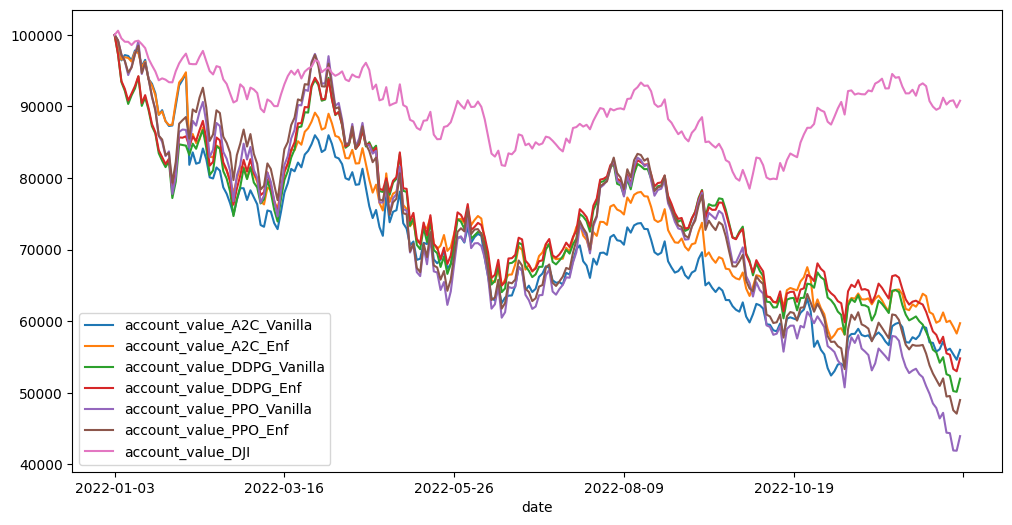

In [20]:
# df_account_value = df_account_value_a2c.merge(df_account_value_ddpg, left_on='date', right_on='date', suffixes=('a2c','ddpg'))
# df_account_value = df_account_value.merge(df_account_value_ppo, left_on='date', right_on='date')
# df_account_value = df_account_value.merge(df_account_value_dji, left_on='date', right_on='date')

# df_account_value.columns = ['date', 'account_value_a2c', 'account_value_ddpg', 'account_value_ppo', 'account_value_dji']
# df_account_value.plot(x='date', y=['account_value_a2c', 'account_value_ddpg', 'account_value_ppo', 'account_value_dji'], figsize=(12,6))

df_account_value = df_account_value_a2c_vanilla.merge(df_account_value_a2c_enf, left_on='date', right_on='date', suffixes=('A2C_Vanilla','A2C_Enf'))
df_account_value = df_account_value.merge(df_account_value_ddpg_vanilla, left_on='date', right_on='date')
df_account_value = df_account_value.merge(df_account_value_ddpg_enf, left_on='date', right_on='date', suffixes=('DDPG_Vanilla','DDPG_Enf'))
df_account_value = df_account_value.merge(df_account_value_ppo_vanilla, left_on='date', right_on='date')
df_account_value = df_account_value.merge(df_account_value_ppo_enf, left_on='date', right_on='date', suffixes=('PPO_Vanilla','PPO_Enf'))
df_account_value = df_account_value.merge(df_account_value_dji, left_on='date', right_on='date')
df_account_value.columns = ['date', 'account_value_A2C_Vanilla', 'account_value_A2C_Enf', 'account_value_DDPG_Vanilla', 'account_value_DDPG_Enf', 'account_value_PPO_Vanilla', 'account_value_PPO_Enf', 'account_value_DJI']
df_account_value.plot(x='date', y=['account_value_A2C_Vanilla', 'account_value_A2C_Enf', 'account_value_DDPG_Vanilla', 'account_value_DDPG_Enf', 'account_value_PPO_Vanilla', 'account_value_PPO_Enf', 'account_value_DJI'], figsize=(12,6))

## Detailed Analysis

/home/shlok/MTP/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-40.526%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2022-01-03
End date,2022-12-29
Total months,11
,Backtest
Annual return,-40.526%
Cumulative returns,-40.281%
Annual volatility,35.019%
Sharpe ratio,-1.31
Calmar ratio,-0.95
Stability,0.82
Max drawdown,-42.456%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.46,2022-01-03,2022-11-03,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/home/shlok/MTP/.venv/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/home/shlok/MTP/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,-0.18%,-10.93%,7.78%


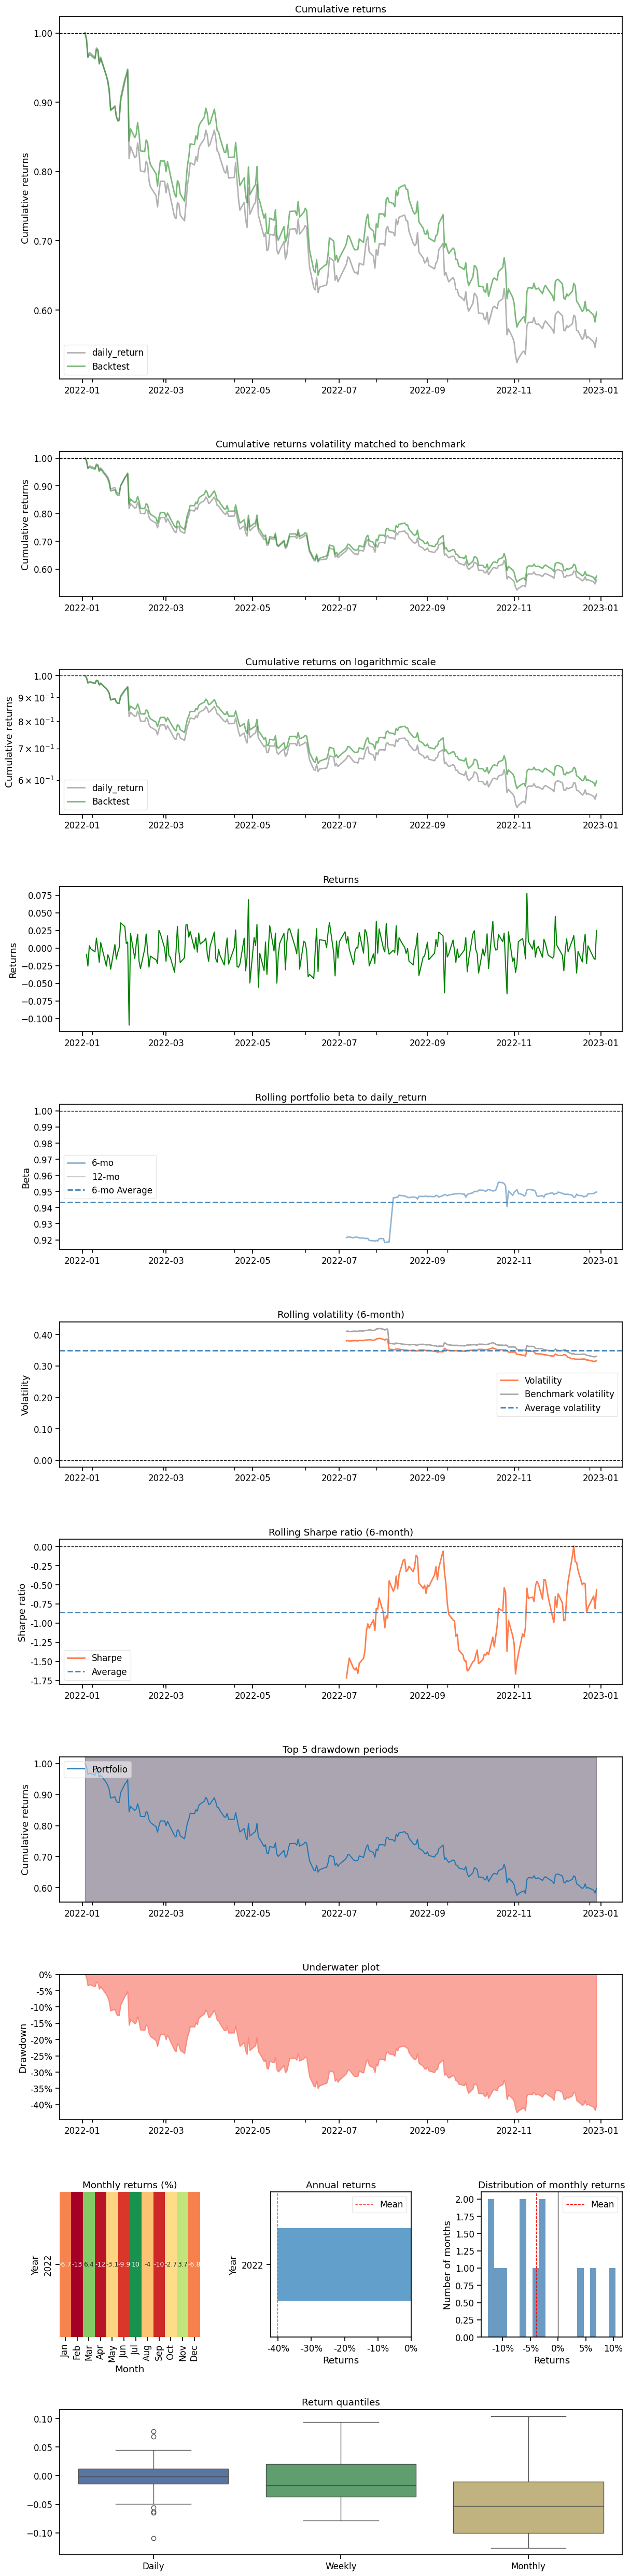

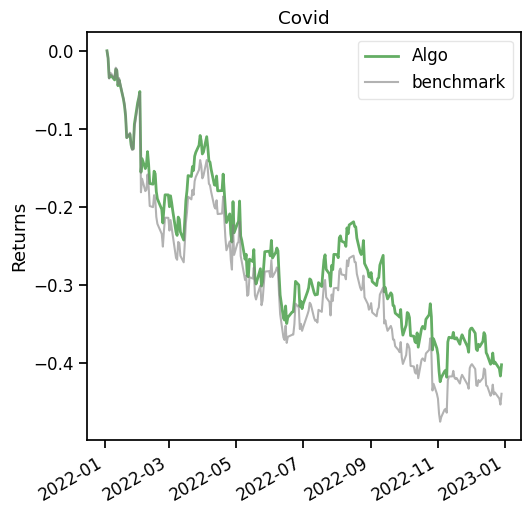

In [40]:
# backtest_plot(df_account_value_a2c_enf,
#                 baseline_start=TRADE_START_DATE,
#                 baseline_end=TRADE_END_DATE)

wo_enf_acc_val = df_account_value_a2c_vanilla
w_enf_acc_val = df_account_value_a2c_enf
value_col_name = "account_value"

wo_enf_acc_val["date"] = pd.to_datetime(wo_enf_acc_val["date"])
wo_enf_returns = get_daily_return(wo_enf_acc_val, value_col_name=value_col_name)

w_enf_acc_val["date"] = pd.to_datetime(w_enf_acc_val["date"])
w_enf_returns = get_daily_return(w_enf_acc_val, value_col_name=value_col_name)

with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(
        returns=w_enf_returns, benchmark_rets=wo_enf_returns, set_context=False
    )